# Import for building essentials

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob
import shutil
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn.modules.loss import BCEWithLogitsLoss, CrossEntropyLoss
from torch.optim import lr_scheduler
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from sklearn.metrics import classification_report, f1_score
import torch
from imblearn.over_sampling import SMOTE
import zipfile
import os
from PIL import Image
import random
import pandas as pd
import numpy as np

# Download shared data dir at Drive

In [ ]:
!rm -rf /content/data

In [ ]:
!rm -rf /content/data/TODO

## Load data split

In [ ]:
!cp -r /content/drive/MyDrive/validation /content/data

# Define dataloader and data transformation via torchvision

In [ ]:
BATCH_SIZE = 16
LEARNING_RATE = 0.00255
EPOCHES = 30
THRESHOLD = 0.4

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn.functional as F
from typing import Any, Callable, cast, Dict, List, Optional, Tuple, Union

class DatasetImageCustom(datasets.DatasetFolder):
    def __init__(
        self,
        root: str,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        loader: Callable[[str], Any] = datasets.folder.default_loader,
        is_valid_file: Optional[Callable[[str], bool]] = None,
        allow_empty: bool = False,
    ):
        super().__init__(
            root,
            loader,
            datasets.folder.IMG_EXTENSIONS,
            transform=transform,
            target_transform=target_transform,
            is_valid_file=is_valid_file,
            allow_empty=allow_empty,
        )
        self.imgs = self.samples

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        path, target = self.samples[index]
        sample = self.loader(path)
        # Extract the filename from the path
        path = self.samples[index][0]
        filename = os.path.basename(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target, filename

In [ ]:
testdir = "/content/drive/MyDrive/validation"
test_transforms = transforms.Compose([transforms.Resize((1024,768)),
                                      transforms.ToTensor(),
                                      torchvision.transforms.Normalize(
                                          mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225],
    ),
                                      ])

test_data = DatasetImageCustom(testdir,transform=test_transforms)

testloader = torch.utils.data.DataLoader(test_data, shuffle = True, batch_size=16)
torch.save(testloader, '/content/testloader_with_transforms.pth')
#testloader = torch.load('/content/testloader_with_transforms.pth')

In [ ]:
traindir = "/content/drive/MyDrive/training"

#transformations
train_transforms = transforms.Compose([transforms.Resize((1024,768)),
                                       transforms.ToTensor(),
                                       torchvision.transforms.Normalize(
                                           mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225],
    ),
                                       ])

#datasets
train_data = DatasetImageCustom(traindir,transform=train_transforms)

#dataloader
trainloader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size=BATCH_SIZE)

## End load data splited

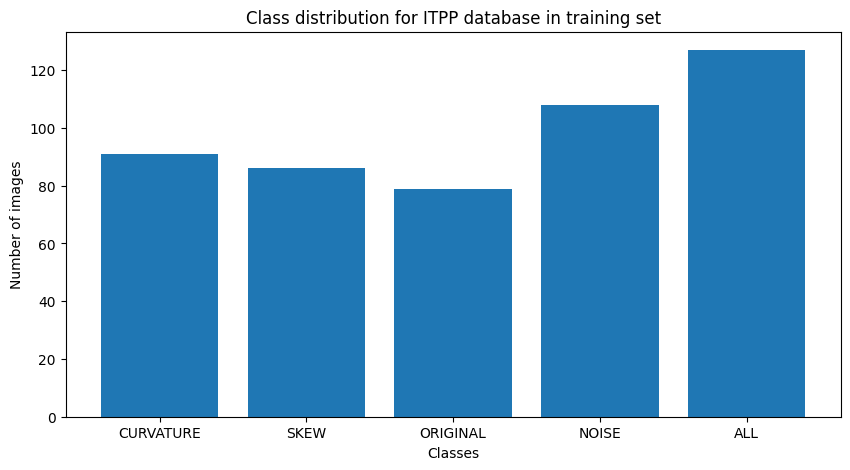

In [ ]:
import matplotlib.pyplot as plt
import os

# Count the number of images in each class in the training directory
class_counts = {}
classes=["CURVATURA","INCLINACION", "ORIGINAL", "RUIDO", "TODO"]
for class_name in classes[:]:
    class_dir = os.path.join(traindir, class_name)
    class_counts[class_name] = len(os.listdir(class_dir))

# Create the bar chart
plt.figure(figsize=(10, 5))
plt.bar(["CURVATURE","SKEW", "ORIGINAL", "NOISE", "ALL"], class_counts.values())
plt.xlabel("Classes")
plt.ylabel("Number of images")
plt.title("Class distribution for ITPP database in training set")
#plt.show()
plt.savefig('training_set_ITPP.pdf', format='pdf')

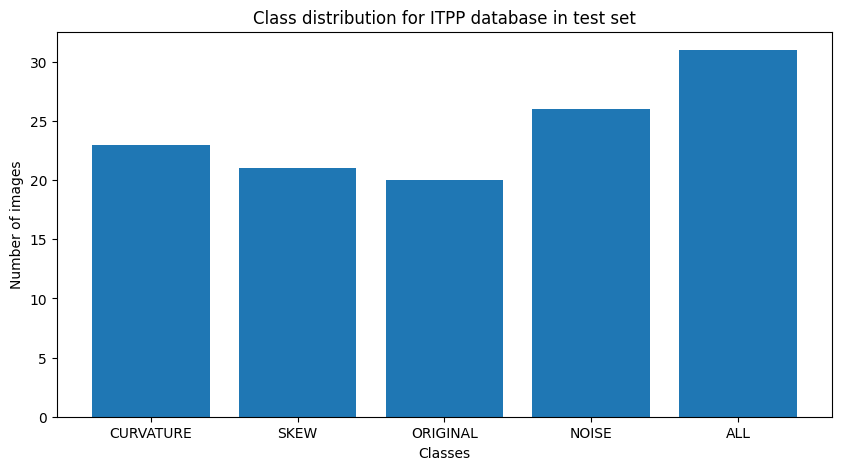

In [ ]:
class_counts = {}
for class_name in classes[:]:
    class_dir = os.path.join(testdir, class_name)
    class_counts[class_name] = len(os.listdir(class_dir))

# Create the bar chart
plt.figure(figsize=(10, 5))
plt.bar(["CURVATURE","SKEW", "ORIGINAL", "NOISE", "ALL"], class_counts.values())
plt.xlabel("Classes")
plt.ylabel("Number of images")
plt.title("Class distribution for ITPP database in test set")
#plt.show()
plt.savefig('test_set_ITPP.pdf', format='pdf')

# Define model and trainer

In [ ]:
class ModelWithSigmoid(nn.Module):
    def __init__(self, model, labels):
        super(ModelWithSigmoid, self).__init__()
        self.model = model
        self.sigmoid = nn.Sigmoid()  # Apply softmax along the class dimension

    def forward(self, x):
        x = self.model(x)
        x = self.sigmoid(x)
        return x

# Model definition

In [ ]:
# Function to count the total number of parameters
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

# Include fined labels for todo

In [ ]:
def get_todo_labels(image_sample_name):
    reverse_mapping_classes = ['CURVATURA', 'INCLINACION', 'ORIGINAL', 'RUIDO']
    one_hot_labels = [0, 0, 0 ,0]
    for index, label in enumerate(reverse_mapping_classes):
        if label in image_sample_name:
            one_hot_labels[index] = 1

    return one_hot_labels

In [ ]:
def make_train_step(model, optimizer, loss_fn):
    def train_step(x, y, image_sample_name):
        yhat = model(x)
        #y=y.squeeze(1).to(torch.int64)
        model.train()
        label_one_hot=[]
        for index, label in enumerate(y):
            if label < 4:
                label_one_hot.append(F.one_hot(label, num_classes=4).float().cpu().numpy().tolist()[0])
            else:
                encoded_label = get_todo_labels(image_sample_name[index])
                label_one_hot.append(encoded_label) # [1,1,0,1] for all

        label_one_hot = torch.tensor(label_one_hot).to(device)
        loss = loss_fn(yhat,label_one_hot)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss

    return train_step

device = "cuda" if torch.cuda.is_available() else "cpu"
model_base = models.resnet34(pretrained=True)

#freeze all params
#for params in model_base.parameters():
    #params.requires_grad_ = False

#add a new final layer
nr_filters = model_base.fc.in_features  #number of input features of last layer
print("features space out: ", nr_filters)

# Replace the final fully connected layer with a new one
model_base.fc = nn.Linear(nr_filters, 4)

model = ModelWithSigmoid(model_base, 4)#

model = model.to(device)

#loss
loss_fn = nn.BCELoss()

for name, param in model.named_parameters():
    if not any(layer_name in name for layer_name in ['model.fc', 'fc1', 'fc2']):
        param.requires_grad = False
    else:
      print(name, 'is not freeze')

# Count the parameters
total_params, trainable_params = count_parameters(model)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

#train step
train_step = make_train_step(model, optimizer, loss_fn)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 56.6MB/s]


features space out:  512
model.fc.weight is not freeze
model.fc.bias is not freeze
Total parameters: 21286724
Trainable parameters: 2052


# Train model with early stoping

# Load model for continue training

In [ ]:
model_path = "/content/drive/MyDrive/trained_model_resnet34_base_threshold.pth"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
losses = []
val_losses = []

epoch_train_losses = []
epoch_test_losses = []

n_epochs = EPOCHES
early_stopping_tolerance = 3
early_stopping_threshold = 0.03

for epoch in range(n_epochs):
    epoch_loss = 0
    for i ,data in tqdm(enumerate(trainloader), total = len(trainloader)): #iterate ove batches
        x_batch , y_batch, image_sample_name = data
        x_batch = x_batch.to(device) #move to gpu
        y_batch = y_batch.unsqueeze(1) #convert target to same nn output shape
        y_batch = y_batch.to(device) #move to gpu


        loss = train_step(x_batch, y_batch, image_sample_name)
        epoch_loss += loss/len(trainloader)
        losses.append(loss)

    epoch_train_losses.append(epoch_loss)
    print('\nEpoch : {}, train loss : {}'.format(epoch+1,epoch_loss))

    #validation doesnt requires gradient
    with torch.no_grad():
        cum_loss = 0
        for x_batch, y_batch, image_sample_name in testloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.unsqueeze(1) #convert target to same nn output shape
            y_batch = y_batch.to(device)

            #model to eval mode
            model.eval()

            yhat = model(x_batch)
            #y_batch=y_batch.squeeze(1).to(torch.int64)

            label_one_hot=[]
            for index, label in enumerate(y_batch):
                if label < 4:
                    label_one_hot.append(F.one_hot(label, num_classes=4).float().cpu().numpy().tolist()[0])
                else:
                    encoded_label = get_todo_labels(image_sample_name[index])
                    label_one_hot.append(encoded_label) # [1,1,0,1] for all

            label_one_hot = torch.tensor(label_one_hot).to(device)
            val_loss = loss_fn(yhat,label_one_hot)
            cum_loss += loss/len(testloader)
            val_losses.append(val_loss.item())


        epoch_test_losses.append(cum_loss)
        print('Epoch : {}, val loss : {}'.format(epoch+1,cum_loss))

        best_loss = min(epoch_test_losses)

        #save best model
        if cum_loss <= best_loss:
            best_model_wts = model.state_dict()

        #early stopping
        early_stopping_counter = 0
        if cum_loss > best_loss:
            early_stopping_counter +=1

        if (early_stopping_counter == early_stopping_tolerance) or (best_loss <= early_stopping_threshold):
            print("/nTerminating: early stopping")
            break #terminate training

#load best model
model.load_state_dict(best_model_wts)

100%|██████████| 31/31 [11:04<00:00, 21.44s/it]



Epoch : 1, train loss : 0.6370670795440674
Epoch : 1, val loss : 0.6300910115242004


100%|██████████| 31/31 [01:59<00:00,  3.85s/it]



Epoch : 2, train loss : 0.5747714638710022
Epoch : 2, val loss : 0.5557445883750916


100%|██████████| 31/31 [01:53<00:00,  3.68s/it]



Epoch : 3, train loss : 0.5485856533050537
Epoch : 3, val loss : 0.5354371070861816


100%|██████████| 31/31 [01:54<00:00,  3.69s/it]



Epoch : 4, train loss : 0.5289023518562317
Epoch : 4, val loss : 0.5275922417640686


100%|██████████| 31/31 [01:56<00:00,  3.76s/it]



Epoch : 5, train loss : 0.5286250710487366
Epoch : 5, val loss : 0.4589967727661133


100%|██████████| 31/31 [01:56<00:00,  3.77s/it]



Epoch : 6, train loss : 0.520879864692688
Epoch : 6, val loss : 0.5584881901741028


100%|██████████| 31/31 [01:57<00:00,  3.80s/it]



Epoch : 7, train loss : 0.508192777633667
Epoch : 7, val loss : 0.4361998438835144


100%|██████████| 31/31 [01:58<00:00,  3.83s/it]



Epoch : 8, train loss : 0.5050999522209167
Epoch : 8, val loss : 0.618910014629364


100%|██████████| 31/31 [01:58<00:00,  3.81s/it]



Epoch : 9, train loss : 0.5026559233665466
Epoch : 9, val loss : 0.46090126037597656


100%|██████████| 31/31 [01:59<00:00,  3.86s/it]



Epoch : 10, train loss : 0.4866849184036255
Epoch : 10, val loss : 0.4717860221862793


100%|██████████| 31/31 [01:59<00:00,  3.85s/it]



Epoch : 11, train loss : 0.5030441880226135
Epoch : 11, val loss : 0.5927593111991882


100%|██████████| 31/31 [01:57<00:00,  3.80s/it]



Epoch : 12, train loss : 0.49197918176651
Epoch : 12, val loss : 0.49698448181152344


100%|██████████| 31/31 [01:57<00:00,  3.79s/it]



Epoch : 13, train loss : 0.4823576807975769
Epoch : 13, val loss : 0.37896907329559326


100%|██████████| 31/31 [01:57<00:00,  3.79s/it]



Epoch : 14, train loss : 0.4830329120159149
Epoch : 14, val loss : 0.5117668509483337


100%|██████████| 31/31 [01:58<00:00,  3.82s/it]



Epoch : 15, train loss : 0.45956745743751526
Epoch : 15, val loss : 0.36796706914901733


100%|██████████| 31/31 [01:58<00:00,  3.81s/it]



Epoch : 16, train loss : 0.4780111610889435
Epoch : 16, val loss : 0.458053857088089


100%|██████████| 31/31 [01:57<00:00,  3.78s/it]



Epoch : 17, train loss : 0.49267831444740295
Epoch : 17, val loss : 0.5860742926597595


100%|██████████| 31/31 [01:57<00:00,  3.80s/it]



Epoch : 18, train loss : 0.4651075005531311
Epoch : 18, val loss : 0.4906131625175476


100%|██████████| 31/31 [01:57<00:00,  3.79s/it]



Epoch : 19, train loss : 0.46490681171417236
Epoch : 19, val loss : 0.473098486661911


100%|██████████| 31/31 [01:57<00:00,  3.79s/it]



Epoch : 20, train loss : 0.4618922472000122
Epoch : 20, val loss : 0.5139637589454651


100%|██████████| 31/31 [01:53<00:00,  3.65s/it]



Epoch : 21, train loss : 0.4819501042366028
Epoch : 21, val loss : 0.5119314193725586


100%|██████████| 31/31 [01:53<00:00,  3.68s/it]



Epoch : 22, train loss : 0.45769864320755005
Epoch : 22, val loss : 0.4244682788848877


100%|██████████| 31/31 [01:54<00:00,  3.70s/it]



Epoch : 23, train loss : 0.4547606408596039
Epoch : 23, val loss : 0.42655083537101746


100%|██████████| 31/31 [01:55<00:00,  3.72s/it]



Epoch : 24, train loss : 0.45829087495803833
Epoch : 24, val loss : 0.27966761589050293


100%|██████████| 31/31 [01:56<00:00,  3.77s/it]



Epoch : 25, train loss : 0.47189152240753174
Epoch : 25, val loss : 0.5010488629341125


100%|██████████| 31/31 [01:55<00:00,  3.73s/it]



Epoch : 26, train loss : 0.45649415254592896
Epoch : 26, val loss : 0.598903238773346


100%|██████████| 31/31 [01:55<00:00,  3.72s/it]



Epoch : 27, train loss : 0.44477683305740356
Epoch : 27, val loss : 0.47187086939811707


100%|██████████| 31/31 [01:55<00:00,  3.73s/it]



Epoch : 28, train loss : 0.45300740003585815
Epoch : 28, val loss : 0.41744285821914673


100%|██████████| 31/31 [01:57<00:00,  3.78s/it]



Epoch : 29, train loss : 0.4376735985279083
Epoch : 29, val loss : 0.5405483245849609


100%|██████████| 31/31 [01:56<00:00,  3.77s/it]



Epoch : 30, train loss : 0.4455079436302185
Epoch : 30, val loss : 0.4781176745891571


<All keys matched successfully>

#Model evaluation

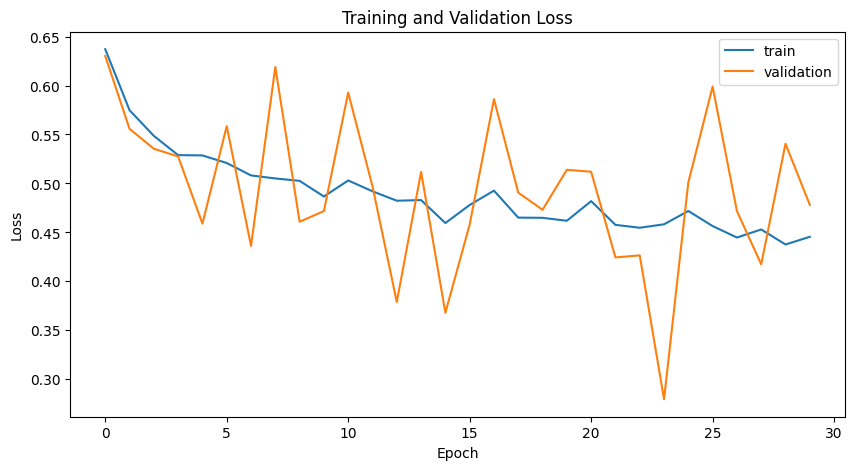

In [ ]:
t_loss=[val.cpu().detach().numpy() for val in epoch_train_losses]
v_loss=[val.cpu().numpy() for val in epoch_test_losses]
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.plot(t_loss, label="train")
plt.plot(v_loss, label="validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/Out models chats/TVL_trained_model_resnet34_base_threshold.pdf', format='pdf')

In [ ]:
def predict_with_thresholds(model, dataloader, device, thresholds):
    """
    Predicts class labels using custom thresholds for each class.

    Args:
        model: The PyTorch model.
        dataloader: The DataLoader for the test data.
        device: The device to run the model on (e.g., 'cuda' or 'cpu').
        thresholds: A list of thresholds, one for each class.

    Returns:
        A list of predicted labels and a list of true labels.
    """
    y_pred = []
    y_true = []

    todo_performance_analize = []

    with torch.no_grad():
        for x_batch, y_batch, image_sample_name in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.unsqueeze(1).float()  # Convert target to same nn output shape
            y_batch = y_batch.to(device)
            model.eval()
            yhat = model(x_batch)
            predictions = yhat.cpu().numpy()

            for i in range(predictions.shape[0]):
                predicted_classes = []
                predicted_classes_ponderations = []
                for j in range(predictions.shape[1]):
                    if predictions[i][j] > thresholds[j]:
                        predicted_classes.append(j)
                        predicted_classes_ponderations.append(predictions[i][j])
                if len(predicted_classes) == 0:
                        y_pred.append(2)
                elif len(predicted_classes) == 1:
                    y_pred.append(predicted_classes[0])

                elif len(predicted_classes) > 1 and 2 not in predicted_classes:
                    predicted_classes_ponderations = np.array(predicted_classes_ponderations)
                    score = np.sum(predicted_classes_ponderations)
                    y_pred.append(4)
                else:
                    max_index = np.argmax(predictions[i])
                    y_pred.append(max_index)

            y_true.extend(y_batch.cpu().numpy().flatten())

    return y_pred, y_true, todo_performance_analize

thresholds =  [0.5, 0.5, 0.5, 0.5]#[0.45, 0.25, 0.35, 0.55] # 0.45, 0.25, 0.35, 0.55
y_pred, y_true, todo_performance_analize = predict_with_thresholds(model, testloader, device, thresholds)

print(classification_report(y_true, y_pred,digits=4, target_names=test_data.classes))

              precision    recall  f1-score   support

   CURVATURA     0.8333    0.4348    0.5714        23
 INCLINACION     0.4211    0.3810    0.4000        21
    ORIGINAL     0.3778    0.8500    0.5231        20
       RUIDO     0.6667    0.6154    0.6400        26
        TODO     0.7619    0.5161    0.6154        31

    accuracy                         0.5537       121
   macro avg     0.6121    0.5594    0.5500       121
weighted avg     0.6324    0.5537    0.5597       121



In [ ]:
# Save the trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/Out models chats/models/trained_model_resnet34_base_threshold.pth')


In [ ]:
# prompt: create all measures f1, macro F, roc

from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, classification_report
from sklearn.preprocessing import label_binarize
import numpy as np

# ... (your existing code) ...

thresholds =  [0.5, 0.5, 0.5, 0.5] #[0.45, 0.25, 0.35, 0.55] # 0.45, 0.25, 0.35, 0.55
y_pred, y_true, todo_performance_analize = predict_with_thresholds(model, testloader, device, thresholds)

# Calculate F1-score (macro average)
f1_macro = f1_score(y_true, y_pred, average='macro')
print(f"Macro F1-score: {f1_macro}")

# Calculate precision and recall
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
print(f"Macro Precision: {precision}")
print(f"Macro Recall: {recall}")

# Classification report
print(classification_report(y_true, y_pred, digits=4, target_names=test_data.classes))


# Calculate ROC AUC score (requires probabilities, not just predictions)
# Binarize the labels for ROC AUC calculation
y_true_binarized = label_binarize(y_true, classes=np.unique(y_pred))

# Assuming your model outputs probabilities
y_prob = []
with torch.no_grad():
    for x_batch, y_batch, image_sample_name in testloader:
        x_batch = x_batch.to(device)
        model.eval()
        yhat = model(x_batch)
        y_prob.extend(yhat.cpu().numpy())
y_prob = np.array(y_prob)

# Calculate ROC AUC for each class
roc_auc_scores = []
n_classes = y_true_binarized.shape[1]
for i in range(4):
    roc_auc = roc_auc_score(y_true_binarized[:, i], y_prob[:, i])
    roc_auc_scores.append(roc_auc)

print(f"ROC AUC scores for each class: {roc_auc_scores}")

# Calculate the macro average of the ROC AUC scores
macro_roc_auc = np.mean(roc_auc_scores)
print(f"Macro-averaged ROC AUC: {macro_roc_auc}")


Macro F1-score: 0.549978021978022
Macro Precision: 0.6121470342522974
Macro Recall: 0.5594497274581426
              precision    recall  f1-score   support

   CURVATURA     0.8333    0.4348    0.5714        23
 INCLINACION     0.4211    0.3810    0.4000        21
    ORIGINAL     0.3778    0.8500    0.5231        20
       RUIDO     0.6667    0.6154    0.6400        26
        TODO     0.7619    0.5161    0.6154        31

    accuracy                         0.5537       121
   macro avg     0.6121    0.5594    0.5500       121
weighted avg     0.6324    0.5537    0.5597       121

ROC AUC scores for each class: [0.4350044365572316, 0.44, 0.41930693069306935, 0.5838056680161944]
Macro-averaged ROC AUC: 0.4695292588166238


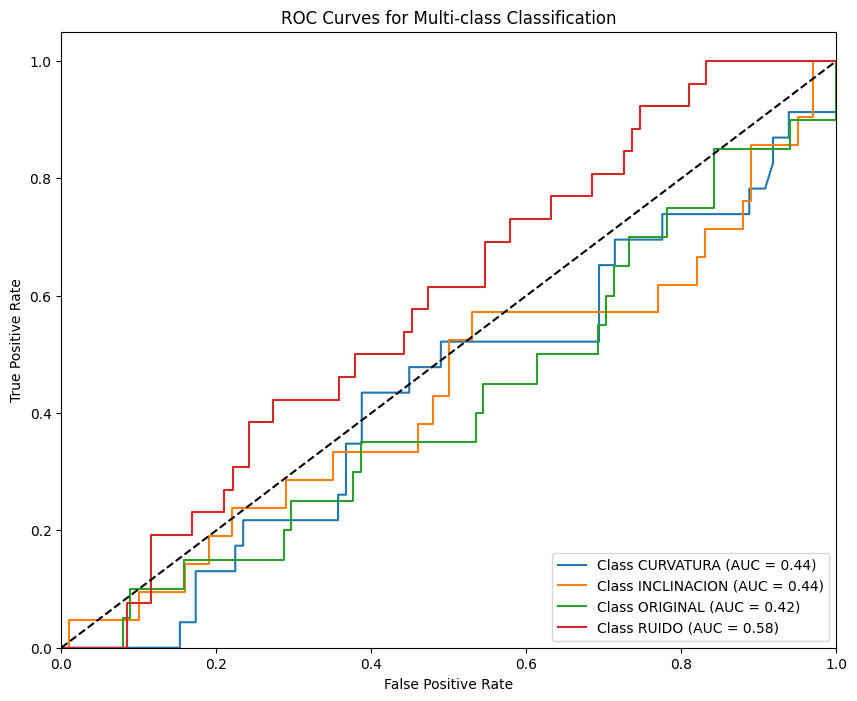

In [ ]:
# prompt: generate chart from ROC

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_true_binarized and y_prob are defined as in your previous code

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_true_binarized.shape[1]

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f'Class {test_data.classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-class Classification')
plt.legend(loc="lower right")
plt.savefig('/content/drive/MyDrive/ROC_trained_model_resnet34_base_threshold.pdf', format='pdf')


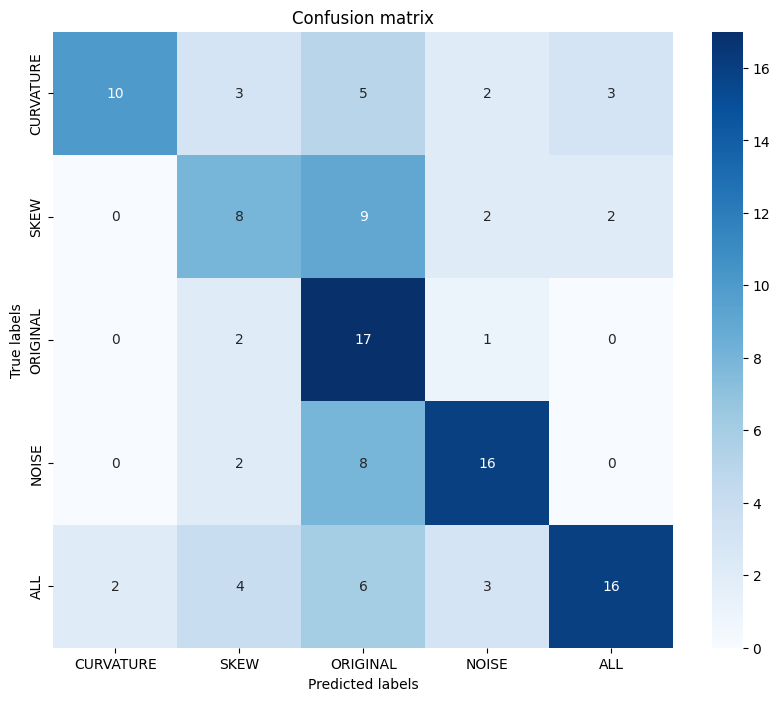

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["CURVATURE","SKEW", "ORIGINAL", "NOISE", "ALL"], yticklabels=["CURVATURE","SKEW", "ORIGINAL", "NOISE", "ALL"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion matrix")
plt.savefig('/content/CM_trained_model_resnet34_base_threshold.pdf', format='pdf')

# Find best thresholds via PSO

In [ ]:
import random

def find_best_thresholds(model, dataloader, device, num_particles=20, max_iterations=25, w=0.8, c1=1.4, c2=1.4):
    """
    Finds the best thresholds using Particle Swarm Optimization (PSO).
    """

    num_classes = 4  # Assuming 4 classes
    particles = []
    velocities = []
    for _ in range(num_particles):
      particles.append([random.uniform(0, 1) for _ in range(num_classes)])
      velocities.append([random.uniform(-0.1, 0.1) for _ in range(num_classes)])

    pbest_positions = particles.copy()
    pbest_scores = [0] * num_particles
    gbest_position = particles[0].copy()
    gbest_score = 0

    min_scores=[]
    max_scores=[]
    avg_scores=[]

    for iteration in range(max_iterations):
        sum_scores = 0.0
        scores_array_iterations=[]
        for i in range(num_particles):
            y_pred, y_true, _ = predict_with_thresholds(model, dataloader, device, particles[i])
            f1_macro = f1_score(y_true, y_pred, average='macro')
            sum_scores += f1_macro
            scores_array_iterations.append(f1_macro)

            if f1_macro > pbest_scores[i]:
                pbest_scores[i] = f1_macro
                pbest_positions[i] = particles[i].copy()

            if f1_macro > gbest_score:
                gbest_score = f1_macro
                gbest_position = particles[i].copy()

            # Update velocity and position
            for j in range(num_classes):
                r1 = random.random()
                r2 = random.random()
                velocities[i][j] = (w * velocities[i][j] +
                                    c1 * r1 * (pbest_positions[i][j] - particles[i][j]) +
                                    c2 * r2 * (gbest_position[j] - particles[i][j]))
                particles[i][j] = max(0, min(1, particles[i][j] + velocities[i][j]))  # Keep within [0,1]
        print(f"Iteration {iteration + 1}: Best F1 = {gbest_score:.4f}, Thresholds = {gbest_position}")
        min_scores.append(min(scores_array_iterations))
        max_scores.append(max(scores_array_iterations))
        avg_scores.append(sum_scores / num_particles)

    return gbest_position, min_scores, max_scores, avg_scores

gbest_position, min_scores, max_scores, avg_scores = find_best_thresholds(model, testloader, device)

Iteration 1: Best F1 = 0.5463, Thresholds = [0.45359714298162146, 0.2740562911381438, 0.48447061114338885, 0.22218374308577682]
Iteration 2: Best F1 = 0.5524, Thresholds = [0.4996612961918515, 0.35717284200582267, 0.6816892522258245, 0.4459529880515578]
Iteration 3: Best F1 = 0.5524, Thresholds = [0.4996612961918515, 0.35717284200582267, 0.6816892522258245, 0.4459529880515578]
Iteration 4: Best F1 = 0.5770, Thresholds = [0.5671722238754563, 0.4484664455992385, 0.7758232355842709, 0.4421733611263323]
Iteration 5: Best F1 = 0.5770, Thresholds = [0.5671722238754563, 0.4484664455992385, 0.7758232355842709, 0.4421733611263323]
Iteration 6: Best F1 = 0.5770, Thresholds = [0.5671722238754563, 0.4484664455992385, 0.7758232355842709, 0.4421733611263323]
Iteration 7: Best F1 = 0.5770, Thresholds = [0.5671722238754563, 0.4484664455992385, 0.7758232355842709, 0.4421733611263323]
Iteration 8: Best F1 = 0.5770, Thresholds = [0.5671722238754563, 0.4484664455992385, 0.7758232355842709, 0.4421733611263

# Final metrics

              precision    recall  f1-score   support

   CURVATURA     0.9091    0.4348    0.5882        23
 INCLINACION     0.4583    0.5238    0.4889        21
    ORIGINAL     0.3947    0.7500    0.5172        20
       RUIDO     0.7083    0.6538    0.6800        26
        TODO     0.7500    0.5806    0.6545        31

    accuracy                         0.5868       121
   macro avg     0.6441    0.5886    0.5858       121
weighted avg     0.6619    0.5868    0.5960       121



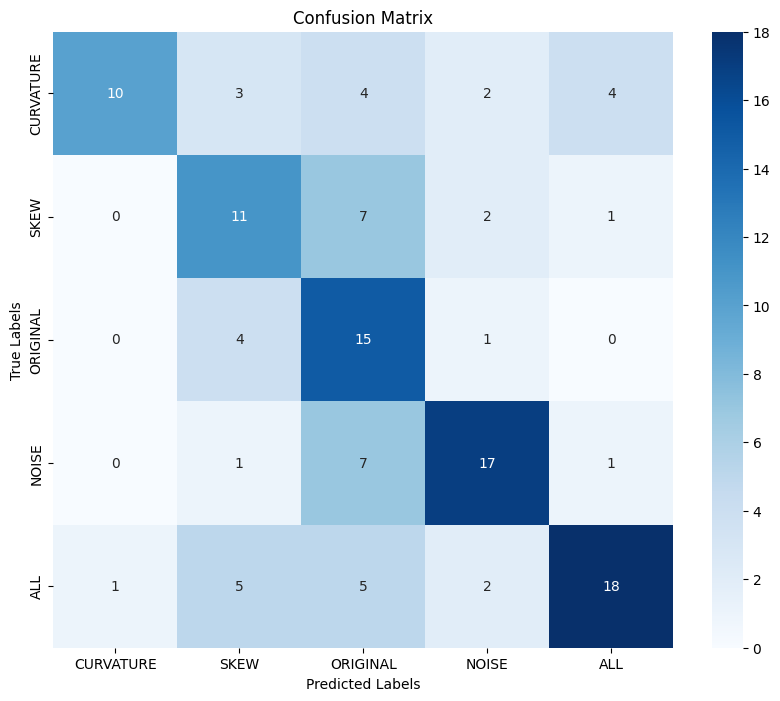

In [ ]:
thresholds =  [0.5322061376403134, 0.45861797531982795, 1, 0.45811994457237437]#[0.45, 0.25, 0.35, 0.55] # 0.45, 0.25, 0.35, 0.55
y_pred, y_true, todo_performance_analize = predict_with_thresholds(model, testloader, device, thresholds)

# Classification report
print(classification_report(y_true, y_pred, digits=4, target_names=test_data.classes))

cm = confusion_matrix(y_true, y_pred)


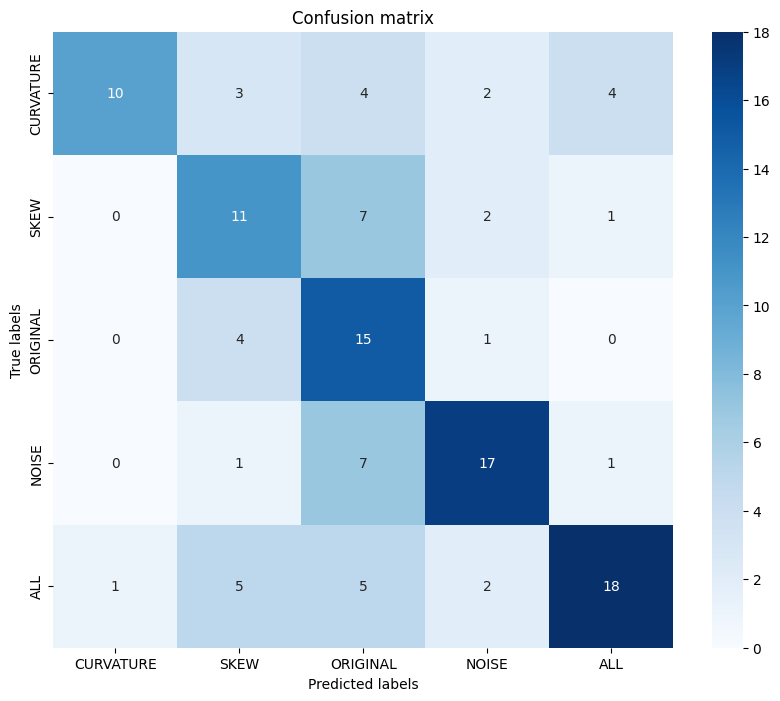

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["CURVATURE","SKEW", "ORIGINAL", "NOISE", "ALL"], yticklabels=["CURVATURE","SKEW", "ORIGINAL", "NOISE", "ALL"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion matrix")
plt.savefig('/content/CM_trained_model_resnet34_base_threshold_pso.pdf', format='pdf')